In [1]:
import numpy as np
import pandas as pd

from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_score

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
def plot_clusters(X, model, fit_predict):
    if fit_predict:
        y_pred = model.fit_predict(X)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

def TSNE_scatter(tsne_model, model, data):
    x = tsne_model.fit_transform(data)
    colors = model.fit_predict(data)
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

def count_clustering_scores(X, model, score_fun):
    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)


def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)


def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [3]:
df = pd.read_csv("../preprocessed_data/preprocessed_pca_train.csv")

# Agglomerative clustering

## Traning, visualisation

Clusters from agglomerative clustering with ward linkage


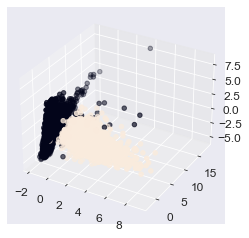

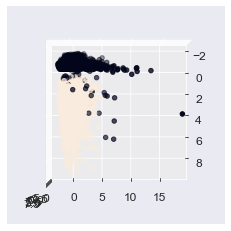

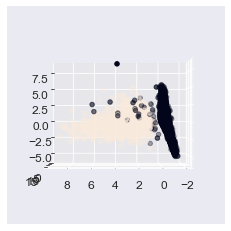

Clusters from agglomerative clustering with average linkage


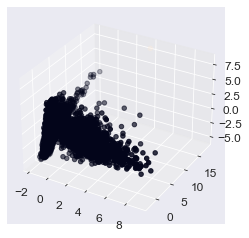

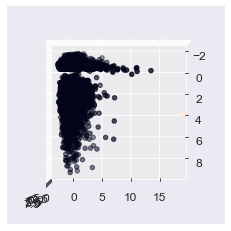

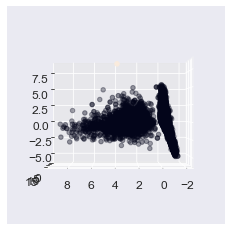

Clusters from agglomerative clustering with single linkage


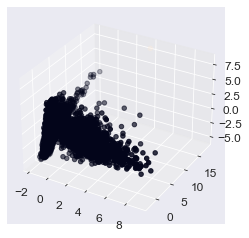

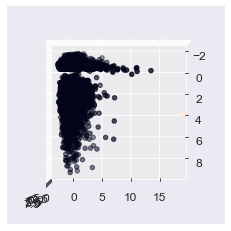

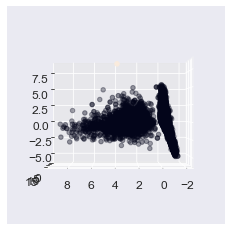

Clusters from agglomerative clustering with complete linkage


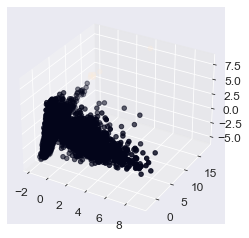

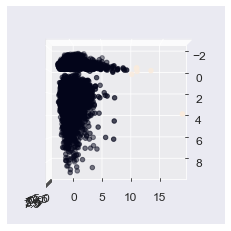

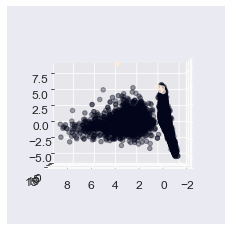

In [4]:
for linkage in {'ward', 'complete', 'average', 'single'}:
    print(f'Clusters from agglomerative clustering with {linkage} linkage')
    plot_clusters(df, AgglomerativeClustering(n_clusters=2, linkage=linkage), True)

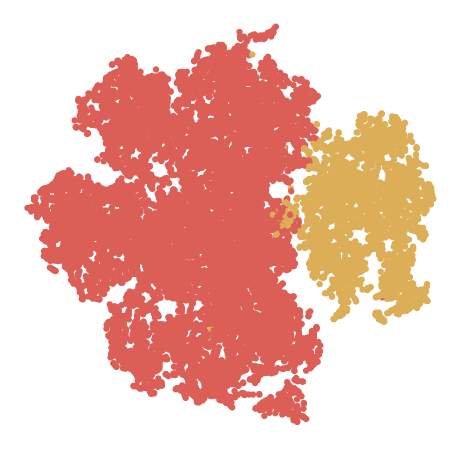

In [5]:
TSNE_scatter(TSNE(n_components=3, random_state=42, n_jobs=1), AgglomerativeClustering(n_clusters=2, linkage='ward'), df)

## Results

In [6]:
metrices = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

models = {
    'Agglomerative ward linkage': AgglomerativeClustering(n_clusters=2, linkage='ward'),
    'Agglomerative complete linkage': AgglomerativeClustering(n_clusters=2, linkage='complete'),
    'Agglomerative average linkage': AgglomerativeClustering(n_clusters=2, linkage='average'),
    'Agglomerative single linkage': AgglomerativeClustering(n_clusters=2, linkage='single'),
}

res = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        res.loc[model_key, metric_key] = count_clustering_scores(X=df, model=models[model_key],
                                                                score_fun=metrices[metric_key])
res

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.928113,3.526179,0.359383,2.466052,0.325829
Agglomerative complete linkage,4.154811,4.825659,1.139018,3.186536,0.823524
Agglomerative average linkage,8.175224,NaN,NaN,1.285424,0.867966
Agglomerative single linkage,8.175224,NaN,NaN,1.285424,0.867966


## Interpretation

In [14]:
clusters = AgglomerativeClustering(n_clusters=2, linkage='ward').fit_predict(df)
row_data = pd.read_csv("../preprocessed_data/train.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))
res_df

In [16]:
res_df.cluster.value_counts()

0    18110
1     4042
Name: cluster, dtype: int64

In [31]:
def get_cluster_data(data):

    col = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
    cl1 = []
    cl0 = []
    for col in col:
        if isinstance(data[col][0], str):
            print( '\ncluster 1')
            print(data.where(data['cluster'] == 1)[col].value_counts(normalize = True))
            print('\n' + 'cluster 0')
            print(data.where(data['cluster'] == 0)[col].value_counts(normalize = True))
            print('\n')
        else:
            cl1.append(data.where(data['cluster'] == 1)[col].median())
            cl0.append(data.where(data['cluster'] == 0)[col].median())
    return pd.DataFrame([col,cl1,cl0])

In [32]:
print(get_cluster_data(res_df))


cluster 1
management       0.225383
blue-collar      0.195695
technician       0.166007
admin.           0.127907
services         0.084364
retired          0.053934
student          0.039090
self-employed    0.035626
unemployed       0.024988
entrepreneur     0.024493
housemaid        0.018803
unknown          0.003711
Name: job, dtype: float64

cluster 0
blue-collar      0.220375
management       0.203534
technician       0.168139
admin.           0.110491
services         0.096742
retired          0.049696
self-employed    0.035229
entrepreneur     0.033793
housemaid        0.029818
unemployed       0.028548
student          0.017062
unknown          0.006571
Name: job, dtype: float64



cluster 1
married     0.575458
single      0.312222
divorced    0.112321
Name: marital, dtype: float64

cluster 0
married     0.611430
single      0.274213
divorced    0.114357
Name: marital, dtype: float64



cluster 1
secondary    0.520040
tertiary     0.315933
primary      0.121227
unknown      

In [27]:
def draw_bar_plots(data):
    clusters = data.cluster
    categorical_columns = data.select_dtypes(include='object').columns

    for column in categorical_columns:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        counts = data.groupby([column, clusters]).size().unstack()
        counts.plot(kind='bar', ax=ax)
        plt.show()


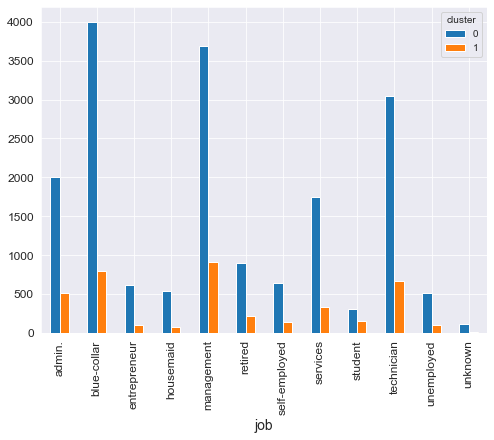

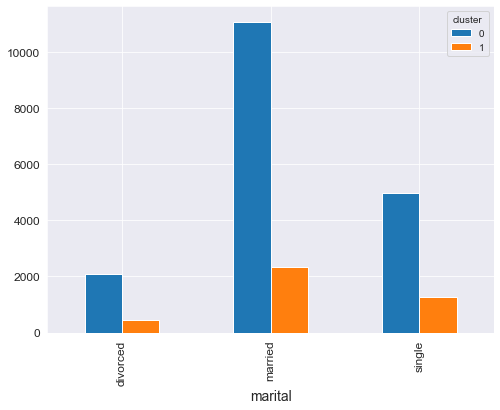

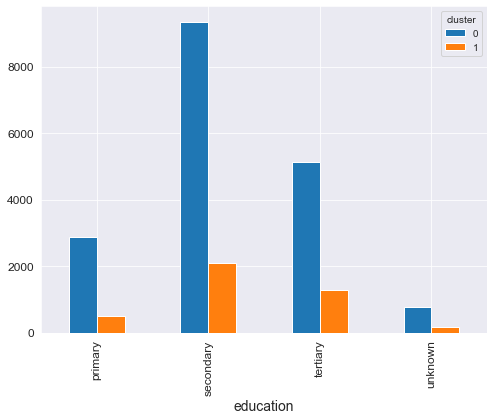

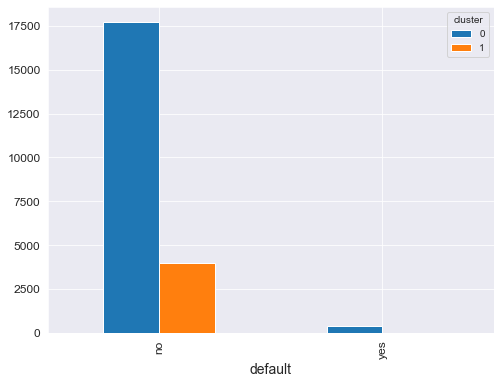

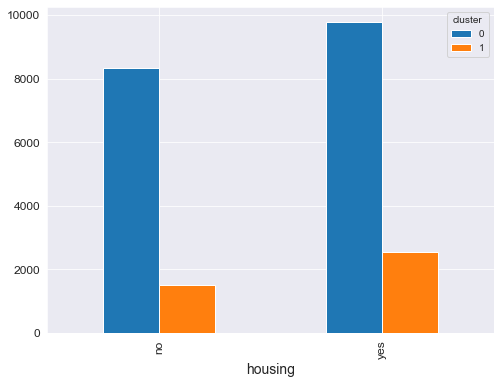

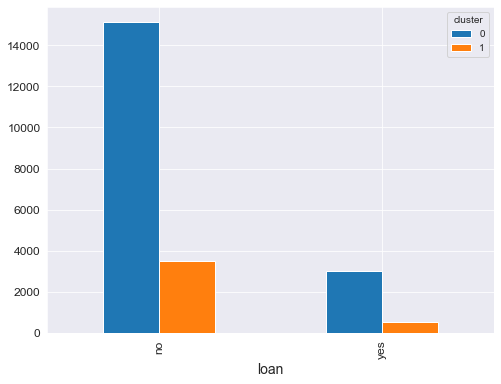

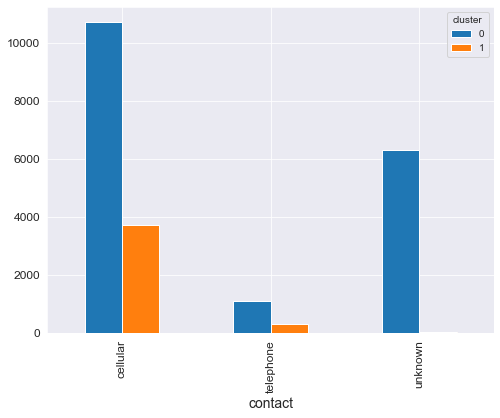

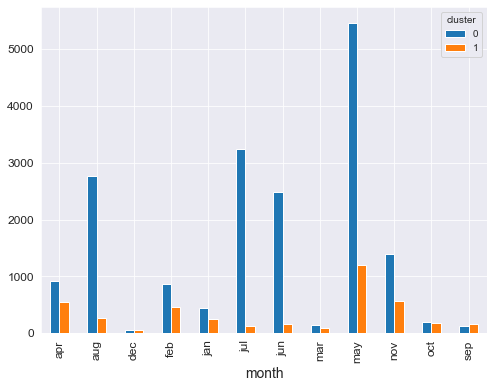

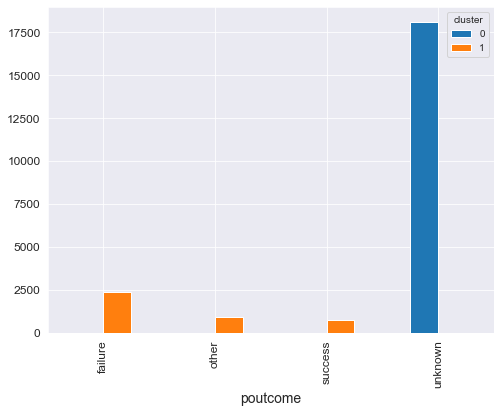

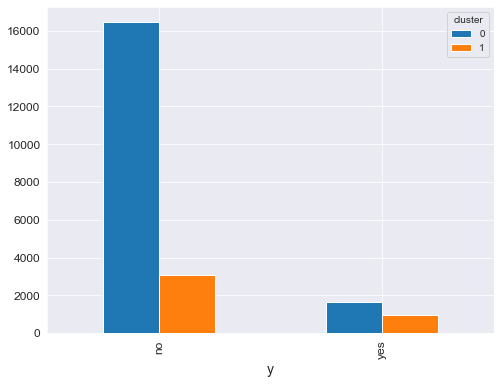

In [28]:
draw_bar_plots(res_df)